# MEPFS Budget Prediction Workflow (End-to-End)

This notebook consolidates the entire workflow for the MEPFS budget prediction model, including data merging, initial visualization, data processing, model training, and evaluation.

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PowerTransformer
from scipy import stats
import lightgbm as lgb
import joblib
import warnings
warnings.filterwarnings('ignore')

## 2. Data Merging (from `csv_merger.py`)

First, we merge the quantity and unit cost CSV files to create a total cost file.

In [2]:
def standardize_project_name(name):
    if not isinstance(name, str):
        return name
    original_name = name
    name_upper = name.upper()
    sty_cl_match = re.search(r'(\d+)\s*STY\s*(\d+)\s*CL(S)?', name_upper)
    if sty_cl_match:
        floors = sty_cl_match.group(1)
        rooms = sty_cl_match.group(2)
        rest_of_name = original_name[sty_cl_match.end():].strip()
        return f"{floors} STY {rooms} CLS {rest_of_name}"
    x_match = re.search(r'(\d+)\s*X\s*(\d+)', name_upper)
    if x_match:
        floors = x_match.group(1)
        rooms = x_match.group(2)
        rest_of_name = original_name[x_match.end():].strip()
        return f"{floors} STY {rooms} CLS {rest_of_name}"
    return original_name

def extract_year_and_budget(entry):
    if not isinstance(entry, str):
        return None, None
    cleaned_entry = re.sub(r'(\d{4})\.', r'\1: ', entry, count=1)
    match = re.match(r'(\d{4}|\d{2}//):\s*(.*)', cleaned_entry.strip())
    if match:
        year_str = match.group(1).replace('//', '00')
        budget_str = match.group(2).replace(',', '')
        if budget_str.count('.') > 1:
            parts = budget_str.split('.')
            budget_str = "".join(parts[:-1]) + "." + parts[-1]
        try:
            budget = float(budget_str)
            return year_str, budget
        except (ValueError, TypeError):
            return year_str, None
    try:
        budget_str = cleaned_entry.replace(',', '')
        if budget_str.count('.') > 1:
            parts = budget_str.split('.')
            budget_str = "".join(parts[:-1]) + "." + parts[-1]
        budget = float(budget_str)
        return None, budget
    except (ValueError, TypeError):
        return None, None

def process_cost_files(quantity_file, unit_cost_file, output_file):
    quantity_df = pd.read_csv(quantity_file)
    unit_cost_df = pd.read_csv(unit_cost_file)
    quantity_df.rename(columns={quantity_df.columns[0]: 'Project', quantity_df.columns[1]: 'Year_Budget'}, inplace=True)
    unit_cost_df.rename(columns={unit_cost_df.columns[0]: 'Project', unit_cost_df.columns[1]: 'Year_Budget'}, inplace=True)
    quantity_df['Original_Project'] = quantity_df['Project']
    year_budget_info = quantity_df['Year_Budget'].apply(extract_year_and_budget).apply(pd.Series)
    quantity_df['Year'] = year_budget_info[0]
    quantity_df['Budget'] = year_budget_info[1]
    quantity_df.set_index('Original_Project', inplace=True)
    unit_cost_df.set_index('Project', inplace=True)
    start_col_index_qty = quantity_df.columns.get_loc('MEPFS aspect') + 1
    numeric_quantity = quantity_df.iloc[:, start_col_index_qty:-2].copy()
    start_col_index_unit = unit_cost_df.columns.get_loc('MEPFS aspect') + 1
    numeric_unit_cost = unit_cost_df.iloc[:, start_col_index_unit:].copy()
    numeric_unit_cost = numeric_unit_cost.reindex(columns=numeric_quantity.columns)
    for col in numeric_quantity.columns:
        numeric_quantity[col] = pd.to_numeric(numeric_quantity[col].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
    for col in numeric_unit_cost.columns:
        numeric_unit_cost[col] = pd.to_numeric(numeric_unit_cost[col].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
    total_cost_df = numeric_quantity.multiply(numeric_unit_cost)
    final_df = quantity_df[['Project', 'Year', 'Budget']].copy()
    final_df['Project'] = final_df['Project'].apply(standardize_project_name)
    final_df = final_df.join(total_cost_df)
    final_df.reset_index(drop=True, inplace=True)
    cols = ['Project', 'Year', 'Budget'] + [col for col in final_df if col not in ['Project', 'Year', 'Budget']]
    final_df = final_df[cols]
    # Clean up unnecessary columns
    final_df = final_df.loc[:, ~final_df.columns.str.contains('^Unnamed')]
    final_df.dropna(axis=1, how='all', inplace=True)
    print(f'Cleaned columns. Remaining columns: {final_df.columns.tolist()}')
    final_df.to_csv(output_file, index=False)
    print(f"Successfully created the merged file: {output_file}")
    return final_df

quantity_filename = 'MEPFS Quantity Cost.csv'
unit_cost_filename = 'MEPFS Unit Cost.csv'
total_cost_filename = 'MEPFS_Total_Cost.csv'
total_cost_df = process_cost_files(quantity_filename, unit_cost_filename, total_cost_filename)

Cleaned columns. Remaining columns: ['Project', 'Year', 'Budget', 'Fire alarm system', 'Panelboard', 'Lighting fixtures', 'Conduits', 'Sewer Line works', 'Plumbing fixtures', 'Wires']
Successfully created the merged file: MEPFS_Total_Cost.csv


## 3. Initial Data Visualization (from `mepfs_visualizer.py`)

Now, let's visualize the distributions of the merged data to check for outliers and skewness.

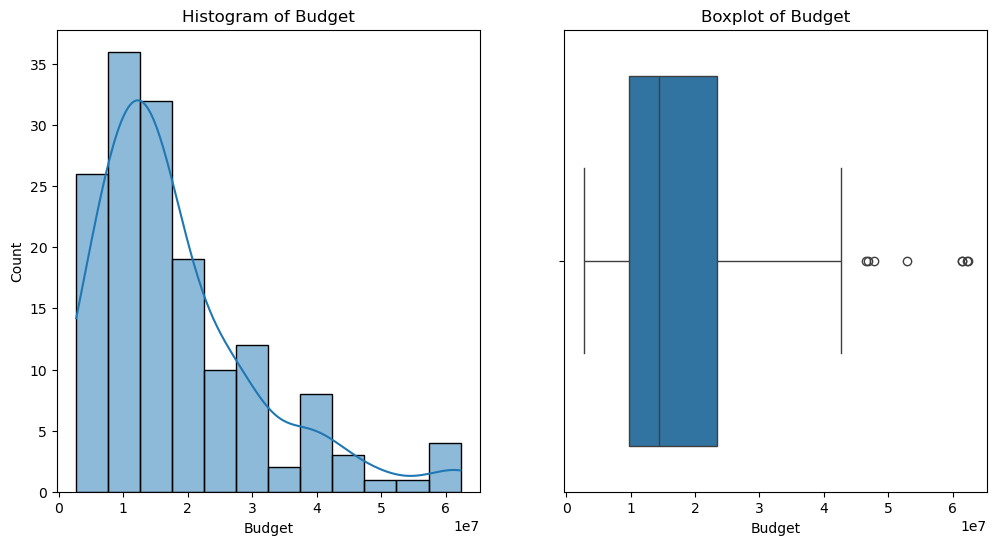

Saved initial visualization for Budget to visualizations\Budget_initial_visualization.png


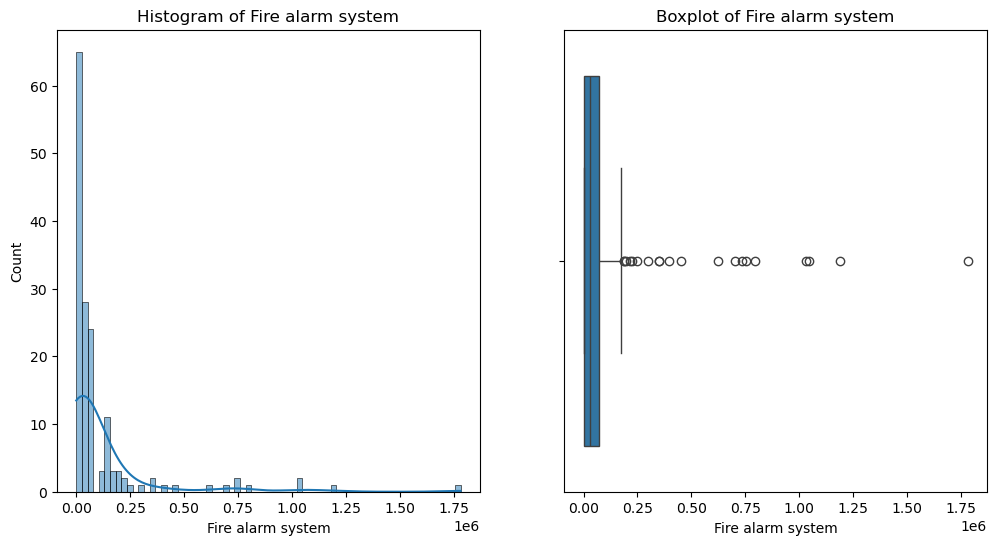

Saved initial visualization for Fire alarm system to visualizations\Fire_alarm_system_initial_visualization.png


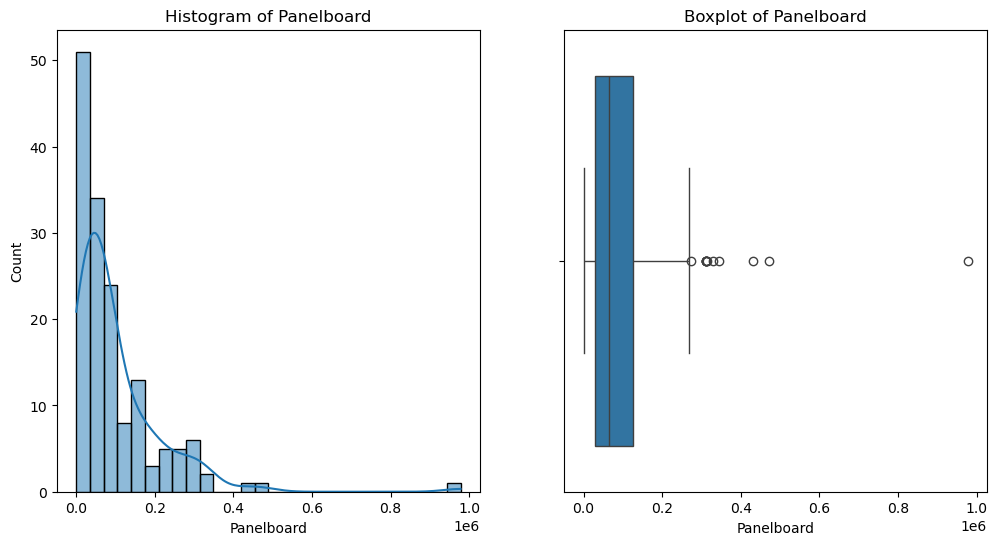

Saved initial visualization for Panelboard to visualizations\Panelboard_initial_visualization.png


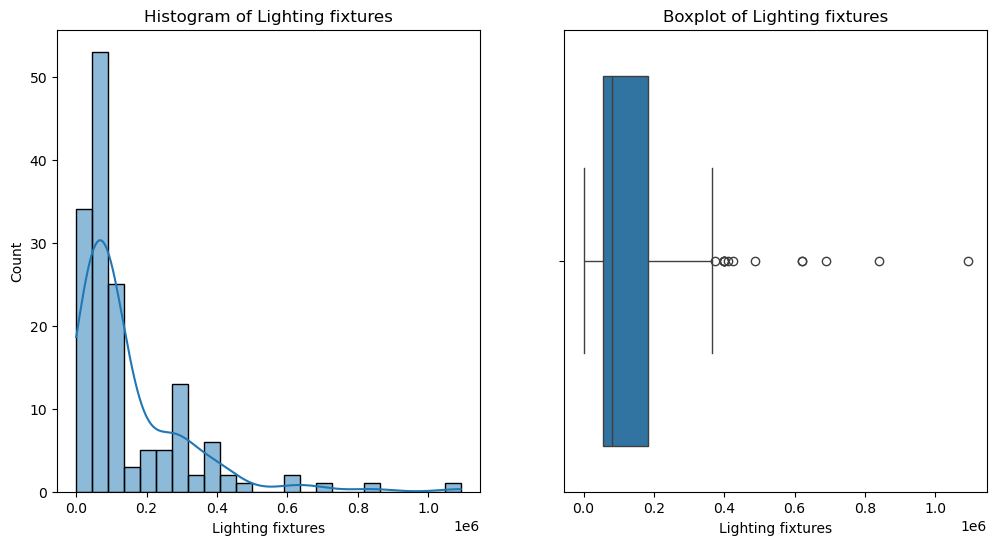

Saved initial visualization for Lighting fixtures to visualizations\Lighting_fixtures_initial_visualization.png


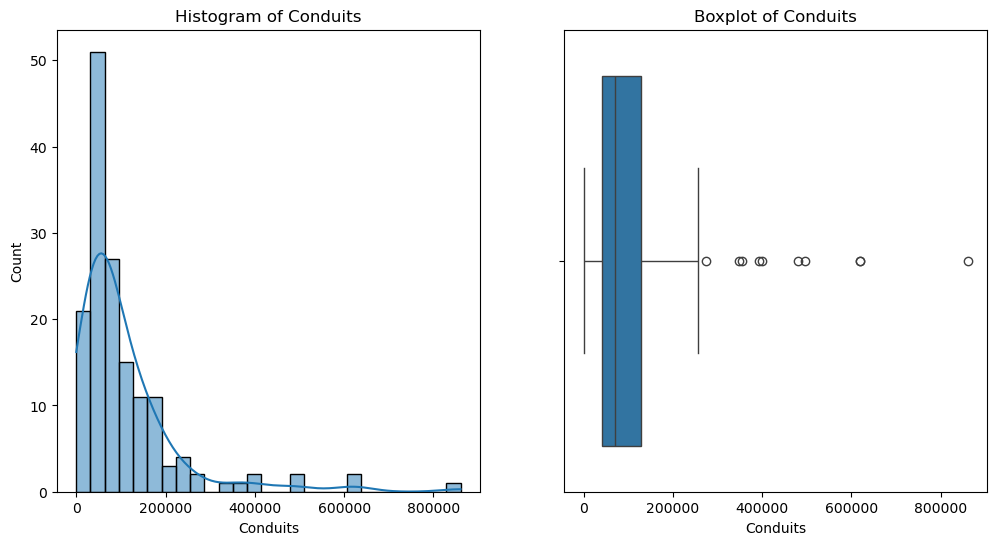

Saved initial visualization for Conduits to visualizations\Conduits_initial_visualization.png


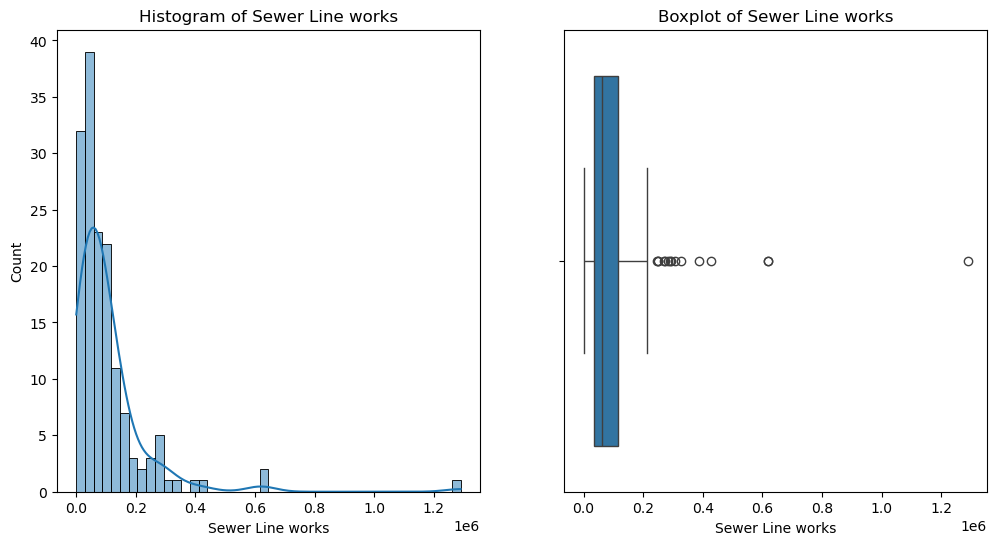

Saved initial visualization for Sewer Line works to visualizations\Sewer_Line_works_initial_visualization.png


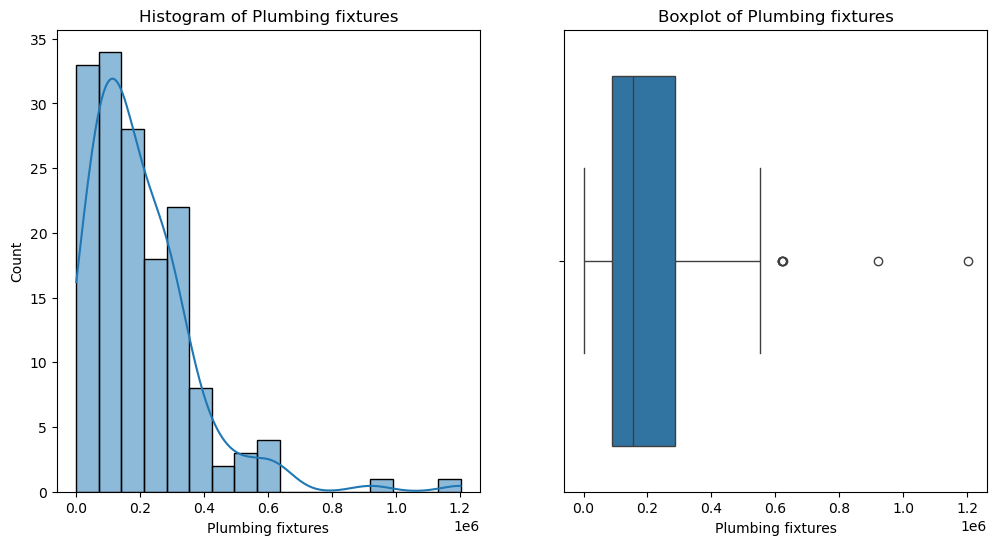

Saved initial visualization for Plumbing fixtures to visualizations\Plumbing_fixtures_initial_visualization.png


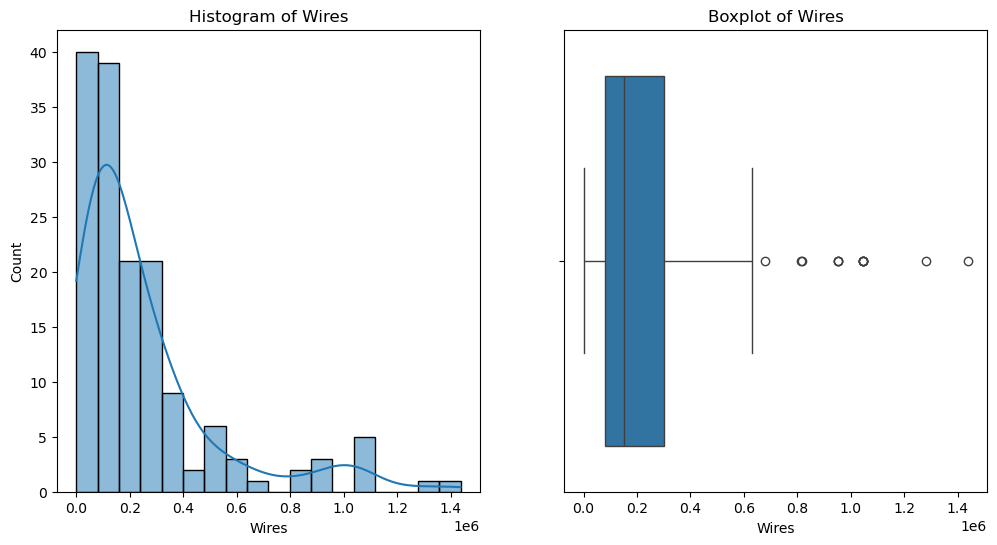

Saved initial visualization for Wires to visualizations\Wires_initial_visualization.png


In [3]:
def visualize_distributions(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    cost_columns = [col for col in df.columns if col not in ['Year', 'Project']]
    for col in cost_columns:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Histogram of {col}')
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col].dropna())
        plt.title(f'Boxplot of {col}')
        safe_col_name = re.sub(r'[^a-zA-Z0-9_]', '_', col)
        filename = os.path.join(output_dir, f'{safe_col_name}_initial_visualization.png')
        plt.savefig(filename)
        plt.show()
        print(f"Saved initial visualization for {col} to {filename}")

VISUALIZATION_DIR = 'visualizations'
visualize_distributions(total_cost_df, VISUALIZATION_DIR)

## 4. Data Preprocessing (from `mepfs_data_processing.py`)

Next, we clean the merged data and filter out irrelevant rows for model training.

In [4]:
def clean_and_transform_data(df, output_filepath):
    df_processed = df.copy()
    cost_columns = [col for col in df_processed.columns if col not in ['Year', 'Project']]
    for col in cost_columns:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
    df_processed.dropna(subset=cost_columns, inplace=True)
    df_processed = df_processed[df_processed['Budget'] > 0]
    feature_columns = [col for col in df_processed.columns if col not in ['Year', 'Budget', 'Project']]
    zero_features_mask = (df_processed[feature_columns] == 0).all(axis=1)
    df_processed = df_processed[~zero_features_mask]
    
    # Remove duplicates - round numeric columns to avoid floating point precision issues
    rows_before = len(df_processed)
    for col in cost_columns:
        df_processed[col] = df_processed[col].round(2)
    df_processed.drop_duplicates(inplace=True)
    rows_after = len(df_processed)
    print(f"Removed {rows_before - rows_after} duplicate rows")
    
    df_processed = df_processed.drop(columns=['Project'])
    df_processed.to_csv(output_filepath, index=False)
    print(f"\nPreprocessed data saved to {output_filepath}")
    return df_processed

PREPROCESSED_DATA_PATH = 'mepfs_preprocessed_data.csv'
preprocessed_df = clean_and_transform_data(total_cost_df, PREPROCESSED_DATA_PATH)

Removed 15 duplicate rows

Preprocessed data saved to mepfs_preprocessed_data.csv


## 5. Feature Engineering and Visualization

Before training the model, we create additional features that might capture more complex relationships in the data. We also apply a log transformation to the 'Budget' target variable to handle its likely right-skewed distribution, which is common for monetary values.

New features created: 'Total_Features_Cost', 'Non_Zero_Features', 'Avg_Cost_Per_Feature'


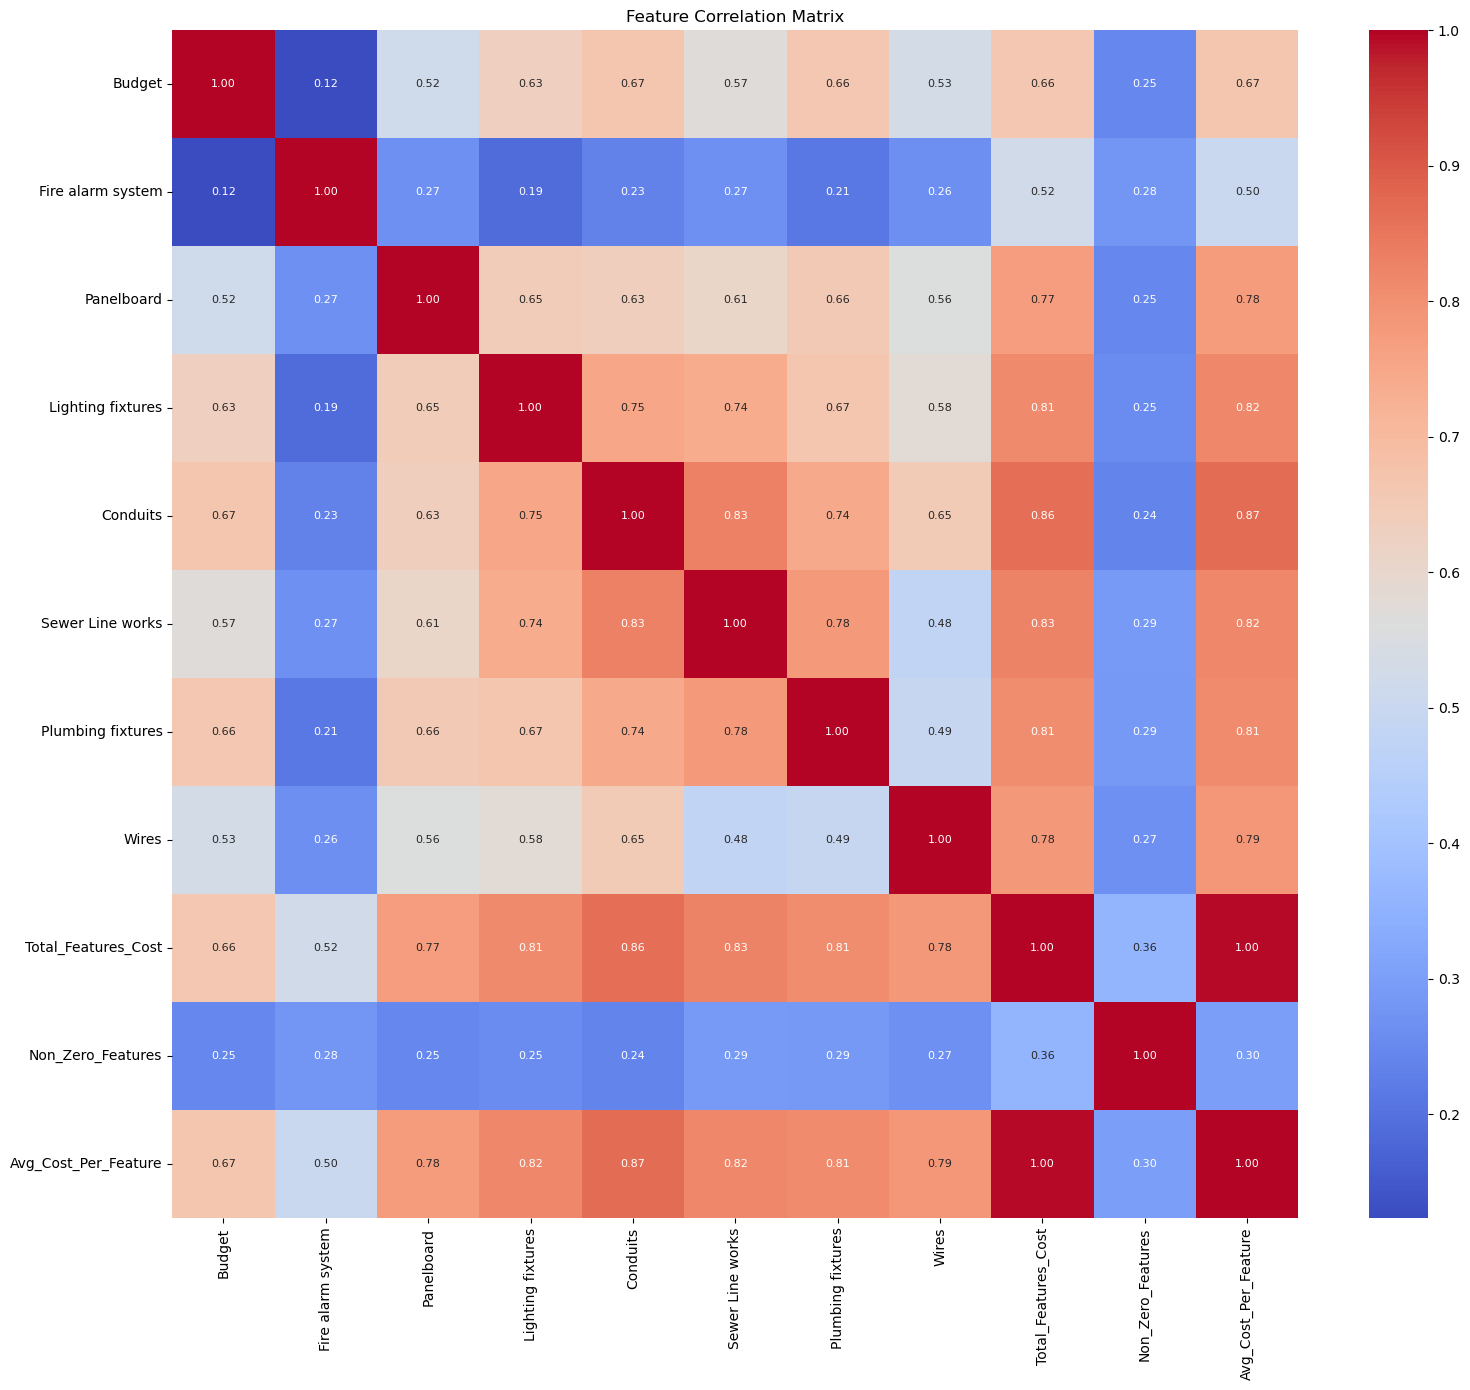

Correlation matrix saved to visualizations\feature_correlation_matrix.png

'Budget' column has been log-transformed.


In [5]:
# Create a copy for feature engineering
df_featured = preprocessed_df.copy()

# Feature Engineering
# 1. Total cost of all MEPFS components
feature_columns = [col for col in df_featured.columns if col not in ['Year', 'Budget']]
df_featured['Total_Features_Cost'] = df_featured[feature_columns].sum(axis=1)

# 2. Count of non-zero MEPFS components
df_featured['Non_Zero_Features'] = (df_featured[feature_columns] > 0).sum(axis=1)

# 3. Average cost per non-zero component
# Adding a small epsilon to avoid division by zero
epsilon = 1e-6
df_featured['Avg_Cost_Per_Feature'] = df_featured['Total_Features_Cost'] / (df_featured['Non_Zero_Features'] + epsilon)

print("New features created: 'Total_Features_Cost', 'Non_Zero_Features', 'Avg_Cost_Per_Feature'")

# Visualize correlations with new features before log transformation
def plot_correlation_matrix(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.figure(figsize=(16, 14))
    # Note: Using the original 'Budget' values for correlation interpretability
    correlation_matrix = df.drop('Year', axis=1, errors='ignore').corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    filename = os.path.join(output_dir, 'feature_correlation_matrix.png')
    plt.savefig(filename)
    plt.show()
    print(f"Correlation matrix saved to {filename}")

plot_correlation_matrix(df_featured, VISUALIZATION_DIR)

# Log transform the target variable 'Budget' to handle skewness
# We use np.log1p which is equivalent to log(1+x) to handle potential zero values
df_featured['Budget'] = np.log1p(df_featured['Budget'])
print("\n'Budget' column has been log-transformed.")

## 6. Advanced Model Training with Hyperparameter Tuning

Here, we replace the manual LightGBM training process with `GridSearchCV`. This not only tests different combinations of hyperparameters to find the best ones but also uses K-fold cross-validation to give a more reliable measure of the model's performance.

Features: Fire alarm system, Panelboard, Lighting fixtures, Conduits, Sewer Line works, Plumbing fixtures, Wires, Total_Features_Cost, Non_Zero_Features, Avg_Cost_Per_Feature
Data split into training (110 rows) and testing (28 rows) sets.

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 313
[LightGBM] [Info] Number of data points in the train set: 110, number of used features: 10
[LightGBM] [Info] Start training from score 16.434064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

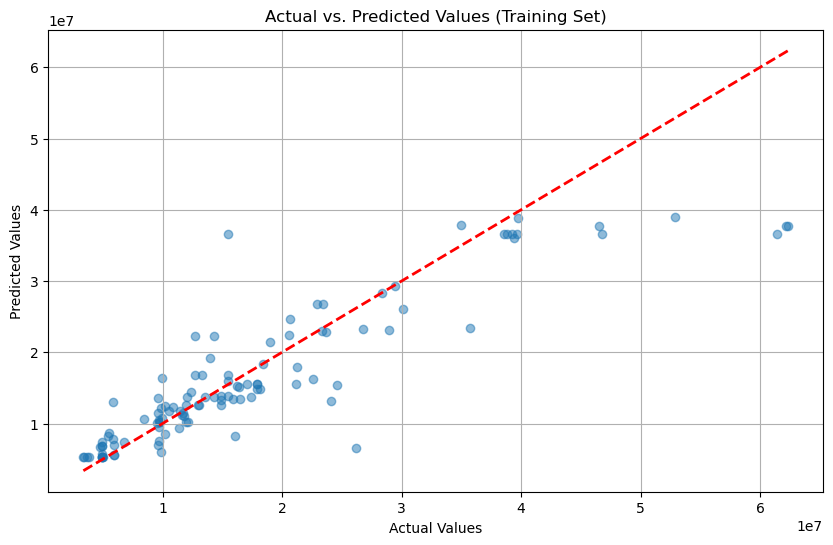

Actual vs. Predicted plot for Training set saved to visualizations\training_actual_vs_predicted.png


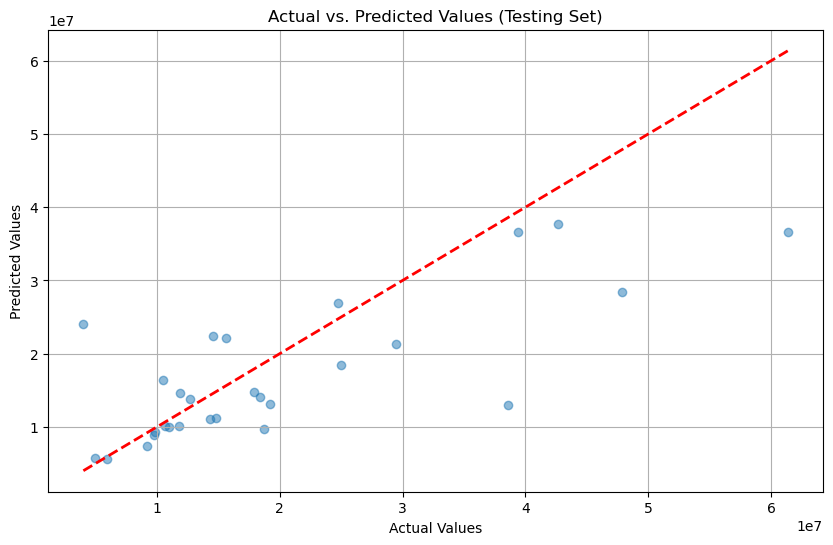

Actual vs. Predicted plot for Testing set saved to visualizations\testing_actual_vs_predicted.png

Trained and tuned model saved to models\mepfs_budget_model_lgbm_tuned.joblib


In [6]:
def plot_actual_vs_predicted(y_true, y_pred, output_dir, data_set_name='Test'):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], '--r', linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs. Predicted Values ({data_set_name} Set)')
    plt.grid(True)
    filename = os.path.join(output_dir, f'{data_set_name.lower()}_actual_vs_predicted.png')
    plt.savefig(filename)
    plt.show()
    print(f"Actual vs. Predicted plot for {data_set_name} set saved to {filename}")

def train_budget_prediction_model_advanced(df, model_output_dir, visualization_dir):
    """
    Trains the model using GridSearchCV for hyperparameter tuning and cross-validation.
    """
    # Using the new engineered features
    X = df.drop('Budget', axis=1)
    y = df['Budget']
    if 'Year' in X.columns:
        X = X.drop('Year', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Features: {', '.join(X.columns)}")
    print(f"Data split into training ({len(X_train)} rows) and testing ({len(X_test)} rows) sets.")

    # --- Hyperparameter Tuning with GridSearchCV ---
    estimator = lgb.LGBMRegressor(objective='regression', metric='l2', random_state=42)
    
    # Define a parameter grid to search. This can be expanded.
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [200, 500, 1000],
        'num_leaves': [20, 31, 40],
        'reg_alpha': [0.1, 0.5],  # L1 regularization
        'reg_lambda': [0.1, 0.5]  # L2 regularization
    }
    
    # Use 5-fold cross-validation
    gsearch = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring='r2', n_jobs=-1, cv=5, verbose=1)
    
    print("\nStarting Hyperparameter Tuning...")
    grid_result = gsearch.fit(X_train, y_train)
    print("Hyperparameter Tuning Complete.")
    
    print(f"\nBest R² Score from CV: {grid_result.best_score_:.2%}")
    print(f"Best Parameters: {grid_result.best_params_}")
    
    # Use the best estimator found by GridSearchCV
    best_model = grid_result.best_estimator_
    
    # --- Evaluate the Final Model ---
    # Remember to transform predictions back from log scale using np.expm1
    y_train_pred_log = best_model.predict(X_train)
    y_train_pred = np.expm1(y_train_pred_log)
    # Transform y_train back as well for evaluation
    y_train_actual = np.expm1(y_train)
    train_r2 = r2_score(y_train_actual, y_train_pred)
    train_mae = mean_absolute_error(y_train_actual, y_train_pred)
    print(f"\nFinal Training Accuracy (R²): {train_r2:.2%}")
    print(f"Final Training MAE: {train_mae:.2f}")
    
    y_test_pred_log = best_model.predict(X_test)
    y_test_pred = np.expm1(y_test_pred_log)
    # Transform y_test back as well for evaluation
    y_test_actual = np.expm1(y_test)
    test_r2 = r2_score(y_test_actual, y_test_pred)
    test_mae = mean_absolute_error(y_test_actual, y_test_pred)
    print(f"Final Testing Accuracy (R²): {test_r2:.2%}")
    print(f"Final Testing MAE: {test_mae:.2f}")
    
    # --- Visualization ---
    # Pass the actual, untransformed values to the plotting function
    plot_actual_vs_predicted(y_train_actual, y_train_pred, visualization_dir, data_set_name='Training')
    plot_actual_vs_predicted(y_test_actual, y_test_pred, visualization_dir, data_set_name='Testing')
    
    # --- Save the Model ---
    if not os.path.exists(model_output_dir):
        os.makedirs(model_output_dir)
    model_filepath = os.path.join(model_output_dir, 'mepfs_budget_model_lgbm_tuned.joblib')
    joblib.dump(best_model, model_filepath)
    print(f"\nTrained and tuned model saved to {model_filepath}")

MODEL_OUTPUT_DIR = 'models'
train_budget_prediction_model_advanced(df_featured, MODEL_OUTPUT_DIR, VISUALIZATION_DIR)

In [ ]:
# Display saved visualization images so they are embedded in the notebook outputs
from IPython.display import Image, display
import glob

viz_dir = 'visualizations'
if os.path.exists(viz_dir):
    for img_path in sorted(glob.glob(os.path.join(viz_dir, '*.png'))):
        display(Image(filename=img_path))
        print(f"Displayed {img_path}")
else:
    print(f"Visualization directory not found: {viz_dir}")